# PROJETO FINAL: TURMA 01 - GRUPO XX

# Integrantes:

i29089 - Nuno Pimentel

i31332 - Jesus Alban

i31433 - Matheus Anjos

i31476 - Diogo Gomes

# Objetivos:
Análise de tendencias relativamente à venda de jogos em diversas plataformas e em diversos países

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
#Variaveis Globais

## Ficheiro CSV de importação
csvFile = 'vgsales-12-4-2019.csv'

## Variaveis a adicionar ao ficheiro de exportação
excelFileName = 'ficheiro.xlsx'
tab1Name = 'Raw Data'
tab2Name = 'Platform Rank'
tab3Name = 'Genre Rank'

# Configuração Pandas CSV
encodingName = 'utf8'
separator = ','

# Configuração do Pandas XLS
engineName = 'xlsxwriter'

# lista de colunas para a limpeza e pre-processamento dos dados
list_columns_delete = ['Rank','basename','VGChartz_Score','Critic_Score','User_Score','Total_Shipped','Last_Update','url','status','Vgchartzscore','img_url','ESRB_Rating']
list_columns_delete_lines_ifnull = ['Genre','Platform','Publisher','Developer','Global_Sales','Year']
list_columns_fill_nulls = ['NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales']

# Definições gráficas
top_10_sum_image = 'top_10_sum_image.png'

Definição das funções relevantes para os objetivos propostos para o projeto final

In [56]:
# Função para remover a coluna de index de uma dataframe
def transform_remove_index(df):
    return df.drop(df.columns[0], axis=1)

In [57]:
# Função para eliminar colunas de um dataframe

def delete_columns(df, *columns_to_delete):
    columns_list = list(columns_to_delete)
    df = df.drop(columns=columns_list, errors='ignore')
    return df

In [58]:
# Função que filtra o dataframe com base nos valores não nulos de uma coluna

def filter_not_null(df,*columns_filter):
    try:
        filtered_df = df
        columns_list = list(columns_filter)
        for column in columns_list:
            if column in df.columns:
                filtered_df = filtered_df[filtered_df[column].notnull()]
        return filtered_df
    except:
        print(f'Column {column} not in DataFrame')

In [59]:
# Função que converte os valores de uma ou mais colunas em integer

def convert_int(df,*inColumn):
    columns_list = list(inColumn)
    for column in columns_list:
        if column in df.columns:
            df[column] = df[column].astype(int)
    return df

In [60]:
# Função que preenche os vazios de uma ou mais colunas

def fill_null(df, *column_name ,fill_value=0):
    for column in column_name:
        if column in df.columns:
            df[column] = df[column].fillna(fill_value)
    return df

In [61]:
# AVALIAR SE VAI PARA A VERSÃO FINAL

# Essa função é responsável por criar uma percentagem de linhas null
def count_null(df,inColumn):
    totalRows = len(df)
    countNull = 0
    for i, row in df.iterrows():
        if pd.isnull(row[inColumn]):
            countNull += 1
    percent = round((countNull * 100) / totalRows,2)
    return percent

In [62]:
# ADAPTAR O CÓDIGO PARA VÁRIOS DF E TABS

# Essa função recebe como parâmetro o pd.ExcelWriter, o file e a tab do excel e escreve no ficheiro
def write_xls(inWriter,df,inTab):
    # Falta código para escrever no ficheiro
    df.to_excel(inWriter, sheet_name=inTab,index=False)

In [63]:
# Função responsável somar valores de uma coluna e agrupar por uma ou mais colunas
# O reset index cria indexes para a nova lista criada
# A função sort_values ordena os dados por ordem descendente da soma
# No final é renomeada a coluna da soma para o nome que se quiser

def sum_column_by_group(df, column, *group_by_column, new_column_name='Sum'):
    group_by_list = list(group_by_column)
    df_sum_grouped = df.groupby(group_by_list)[column].sum().reset_index()
    
    df_sum_sorted = df_sum_grouped.sort_values(by=column, ascending = False).reset_index(drop=True)
    df_sum_sorted.rename(columns={column: new_column_name}, inplace = True)
    return df_sum_sorted

In [64]:
# Função responsável por cacular a média dos valores de uma coluna e agrupar por uma ou mais colunas
# O reset index cria indexes para a nova lista criada
# A função sort_values ordena os dados por ordem descendente da média
# No final é renomeada a coluna da soma para o nome que se quiser

def mean_column_by_group(df, column, *group_by_column, new_column_name='Average'):
    group_by_list = list(group_by_column)
    df_mean_grouped = df.groupby(group_by_list)[column].mean().reset_index()
    
    df_mean_sorted = df_mean_grouped.sort_values(by=column, ascending = False).reset_index(drop=True)
    df_mean_sorted.rename(columns={column: new_column_name}, inplace = True)
    return df_mean_sorted

In [65]:
# Função calcula a percentagem dos valores de uma coluna em função de um grupo

def percentage_by_group(df,inColumnMeasure,total_column_name,group_by_column,new_column_name='percentage'):
    total_sum = df[inColumnMeasure].sum()
    Sum_per_group = sum_column_by_group(df, inColumnMeasure, group_by_column, new_column_name=total_column_name)
    i = 0    
    while i < len(Sum_per_group):
        Sum_per_group.loc[i, new_column_name] = round(Sum_per_group.loc[i, total_column_name] / total_sum * 100,2)
        i += 1

    Sum_per_group = Sum_per_group.sort_values(by=new_column_name, ascending = False).reset_index(drop=True)

    return Sum_per_group


In [66]:
# Função com a configuração para o plot de um gráfico de linhas

def plot_trends(df, x_column, y_column, hue_column, title_name, xlabel_name, ylabel_name, legend_name, marker_type='o'):
    # Set the plot size
    plt.figure(figsize=(12, 6))
    
    # Create a line plot
    sns.lineplot(data=df, x=x_column, y=y_column, hue=hue_column, marker=marker_type)
    
    # Add titles and labels
    plt.title(title_name)
    plt.xlabel(xlabel_name)
    plt.ylabel(ylabel_name)
    plt.legend(title=legend_name)
    
    # Show the plot
    plt.show()

In [67]:
# Função com a configuração para o plot de um gráfico de barras

def plot_trends_bar(df, x_column, y_column, title_name, xlabel_name, ylabel_name, legend_name, image_name):
    # Set the plot size
    plt.figure(figsize=(12, 6))
    
    # Create a line plot
    sns.barplot(x=x_column,y=y_column,data=df)
    
    # Add titles and labels
    plt.title(title_name)
    plt.xlabel(xlabel_name)
    plt.ylabel(ylabel_name)
    plt.legend(title=legend_name)

    plt.legend(title=legend_name)
    plt.savefig(image_name)

    plt.show()


# Tarefa 1: Extração de dados

In [68]:
file = pd.read_csv(csvFile,sep=separator,encoding=encodingName)

# Tarefa 2:  Limpeza e Pré-Processamento de Dados

In [69]:
file = transform_remove_index(file)

file = delete_columns(file,*list_columns_delete)
file = filter_not_null(file,*list_columns_delete_lines_ifnull)
file = convert_int(file,'Year')
file = fill_null(file, *list_columns_fill_nulls)

# Tarefa 3: Exploratory Data Analysis (EDA)

C:\Users\mathe\AppData\Local\Temp\ipykernel_6984\4073139822.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=legend_name)
C:\Users\mathe\AppData\Local\Temp\ipykernel_6984\4073139822.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=legend_name)


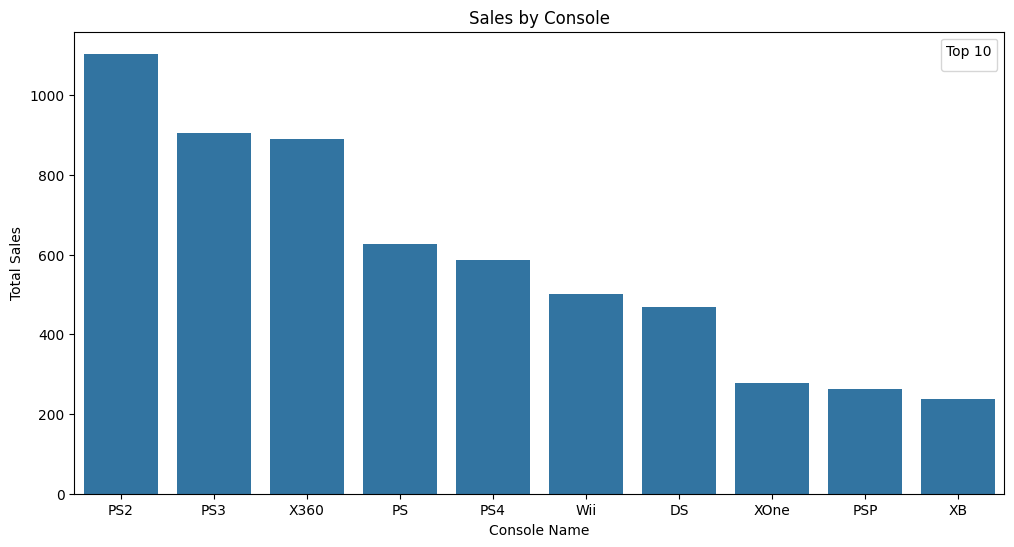

C:\Users\mathe\AppData\Local\Temp\ipykernel_6984\4073139822.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=legend_name)
C:\Users\mathe\AppData\Local\Temp\ipykernel_6984\4073139822.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=legend_name)


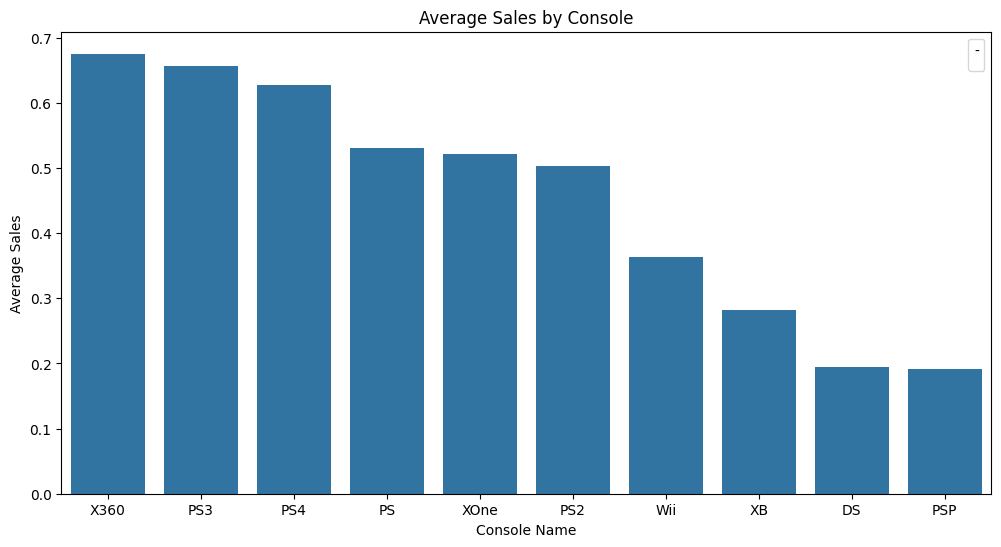

In [70]:
# Total de vendas por plataforma
sum_global_by_platform = sum_column_by_group(file, 'Global_Sales', 'Platform', new_column_name='Total_Global_Sales')

# Top 10 plataformas com mais vendas globais
top_10_global_sales_platforms = sum_global_by_platform.head(10)

# Aqui o file principal é filtrado somente por as 10 plataformas que mais venderam
file_filtered_top_10_sales = file[file['Platform'].isin(top_10_global_sales_platforms['Platform'])]

# Média de vendas entre as 10 plataformas que mais venderam jogos
mean_global_by_platform = mean_column_by_group(file_filtered_top_10_sales, 'Global_Sales', 'Platform', new_column_name='Average_Global_Sales')

# Porcentagem de vendas por Género
percentage_by_group = percentage_by_group(file,'Global_Sales','Total_Genre_Global_Sales','Genre',new_column_name ='Percentage')

plot_trends_bar(top_10_global_sales_platforms, 'Platform', 'Total_Global_Sales', 'Sales by Console', 'Console Name', 'Total Sales','Top 10',top_10_sum_image)
plot_trends_bar(mean_global_by_platform.head(10), 'Platform', 'Average_Global_Sales', 'Average Sales by Console', 'Console Name', 'Average Sales','-',top_10_sum_image)


# Tarefa 4: Gravar dados em ficheiro Excel

In [71]:
with pd.ExcelWriter(excelFileName, engine=engineName) as writer:
    file.to_excel(writer, sheet_name=tab1Name, startrow=0, startcol=0, index=False)  # Grava na coluna A
    
    sum_global_by_platform.to_excel(writer, sheet_name=tab2Name, startrow=0, startcol=0, index=False)  # Grava na coluna A
    mean_global_by_platform.to_excel(writer, sheet_name=tab2Name, startrow=0, startcol=3, index=False)  # Grava na coluna D
    
    percentage_by_group.to_excel(writer,sheet_name=tab3Name,startrow=0,startcol=0,index=False)

    # Inserção do gráfico de barras na tab2
    workbook = writer.book
    worksheet = writer.sheets[tab2Name]
    x_scale = 0.6  # Reduz para 60% do tamanho original
    y_scale = 0.6  # Reduz para 60% do tamanho original
    worksheet.insert_image('I1', top_10_sum_image, {'x_scale': x_scale, 'y_scale': y_scale})


writer.close()

c:\Program Files\Python312\Lib\site-packages\xlsxwriter\workbook.py:369: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
